In [ ]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string
import numpy as np
import pandas as pd
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)
import collections
import scipy as sp
import gensim
import gensim.downloader as api
import nltk, nltk.data
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import json
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import wordnet
from tqdm.notebook import tqdm
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from argparse import Namespace

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<Figure size 640x640 with 0 Axes>

In [ ]:
!pip install ipython-autotime
%load_ext autotime

time: 263 µs (started: 2021-10-26 15:14:20 +00:00)


# <center>Project 2 Natural Language for NLP -- Task 3 </center>

<center>   

**Name_ Student number:**
<br>
Chanxin Xie_22566456
<br>
Yiyong Duan_22628103<br>

**Date created:** Oct 5th 2022<br>
**Last modified:** Oct 25th 2022<br>


# Task 3 NER
Build a Seq2Seq model using the architecture of your choice, and discuss the performance by selecting 50 sentences from the test dataset to compare the Seq2Seq results with the provided labels:


*   What's the percentage of disagreement?
*   Are there newly tagged entitites that actually make sense?



# This notebook contains all details about Task 3: NER Labelling

**This task follows the procedures listed below:**

1. Data Pre-processing and Preparation
2. Split the training/testing/validation dataset
3. Modelling
<br>
(1) Perform word embedding
<br>
(2) Group data into minibatch for the model via DataLoader
<br>
(3)Train Model
4. Evaluation
5. Compare performance

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

%cd /content/drive/MyDrive/NLP/

Mounted at /content/drive
/content/drive/MyDrive/NLP
time: 1min 17s (started: 2021-10-26 15:14:25 +00:00)


#### Import

## 1 Data Preprocessing and Preparation
In this section, we need to first import the 'us_accidents.txt' file, then preprocess the data so that we could construct the narrative text field and their corresponding annotation for modelling.

In [ ]:
file = open('us_accidents.txt', encoding='ISO-8859-1')
list_of_lists = []

for line in file:
  # get lines
  stripped_line = line.strip()
  line_list = stripped_line.rsplit('\n', 1)
  for item in line_list:
    # list of lists, each list contains two elements
    list_of_lists.append(item.rsplit(' ', 1))

# Construct the table 
df = pd.DataFrame(list_of_lists, columns =['source', 'target']) 

time: 2.44 s (started: 2021-10-26 13:13:56 +00:00)


From the figures and bar chart below, we can see that the proportion of labels are highly imbalanced, where label 'O' is predominant, account for about 88.8% of the total instances. B-person/employee comes the second, which only account for 2.7% of the total instances. Other labels only account for less than 1% of the total. This could affect the model performance as most of the narrative text might be labelled as 'O'.


In [ ]:
(df.target.value_counts()/len(df.target)).sort_values(ascending = False)

O                                            0.887869
B-person/employee                            0.026521
B-accident_cause/fall                        0.006252
B-body_part/back                             0.003871
B-body_part/arm/hand                         0.001779
                                               ...   
B-location/kitchen                           0.000005
B-equipment/headframe                        0.000002
I-vehicle/light_vehicle/mine_car             0.000002
B-vehicle/light_vehicle/mine_car             0.000002
B-equipment/personal_protective_equipment    0.000002
Name: target, Length: 176, dtype: float64

time: 77.1 ms (started: 2021-10-26 09:41:29 +00:00)


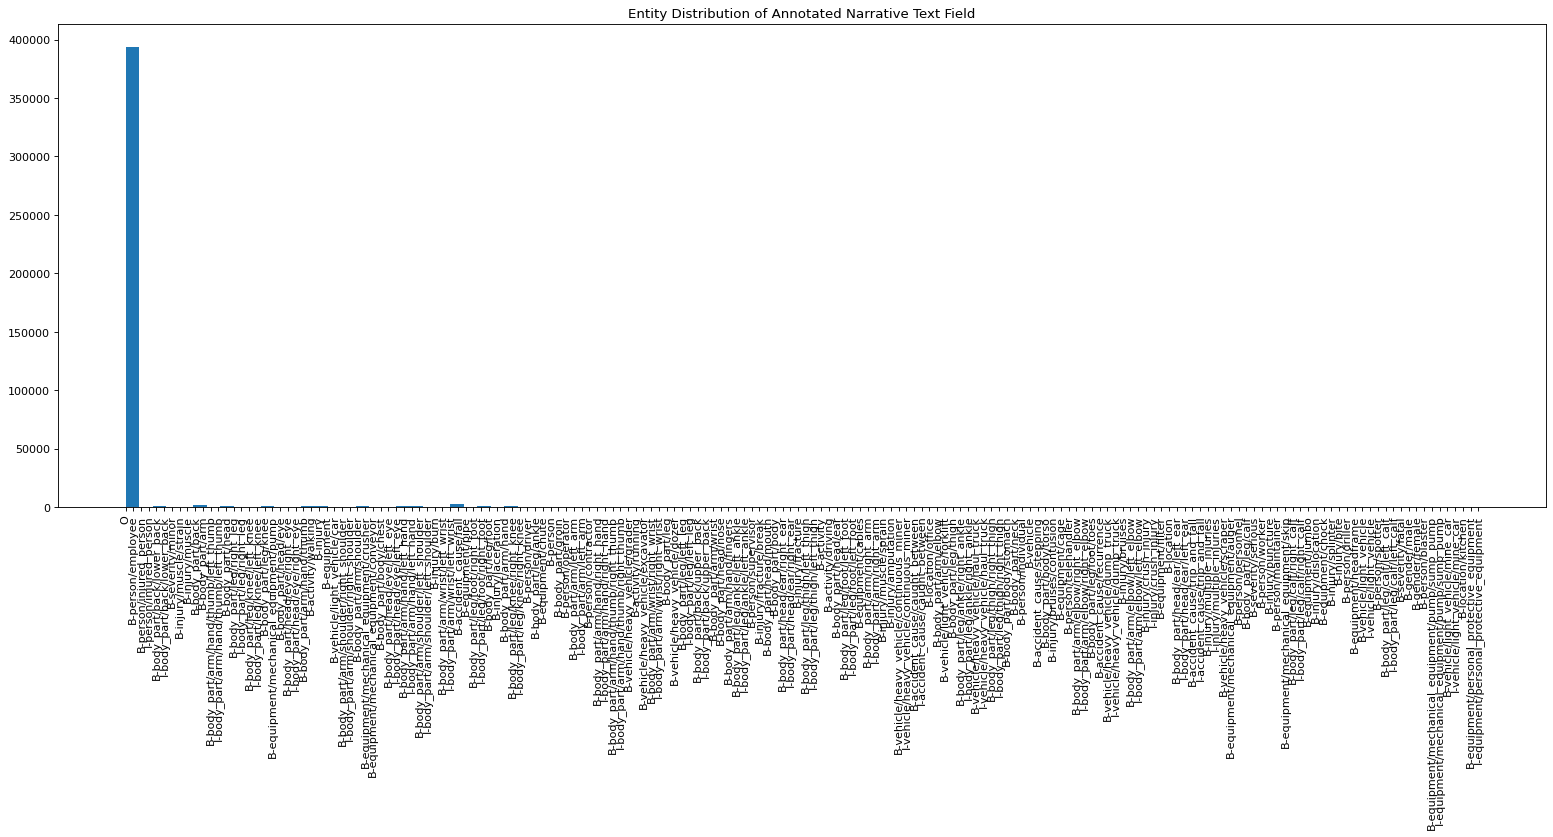

time: 3.76 s (started: 2021-10-26 09:41:29 +00:00)


In [ ]:
figure(figsize=(24, 8), dpi=80)
# df["classes"].hist()
plt.hist([x for x in df["target"] if x is not None], 100, density= False)
plt.xticks(rotation='vertical')
plt.title('Entity Distribution of Annotated Narrative Text Field')
plt.show()

In [ ]:
# Concatenate the source-narrative text and the target- labels
source = ''
target = ''

for i in range(df.shape[0]):
  if df.iloc[i, 1] == None and df.iloc[i, 0] == '':
    source = source + '******' + ' '
    target = target + '******' + ' '
  elif df.iloc[i, 1] == None and df.iloc[i, 0] != '':
    pass
  else:
    source = source + df.iloc[i, 0] + ' '
    target = target + df.iloc[i, 1] + ' '

time: 4min 6s (started: 2021-10-26 09:41:33 +00:00)


In [ ]:
source_language = source.split('******')
target_language = target.split('******')

time: 7.08 ms (started: 2021-10-26 09:45:40 +00:00)


#### Dataset of the preprocessed data
The dataset looks like below after the data preprocessing. 
<br>
We need to use the source - narrative text field to predict the target- orresponding annotation.

In [ ]:
df_language = pd.DataFrame({'source_language': source_language,'target_language': target_language})
df_language.head()

,source_language,target_language
0,he was pulling a 54 inch v wiper and felt pain...,O O O O O O O O O O O O O O O
1,breathing difficulties . employee provided fi...,O O O B-person/employee O O O O O O O O
2,while palletizing flat rock ( landscape stone...,O O O O O O O O B-person/injured_person I-per...
3,employee was helping load bolts on roof bolte...,B-person/employee O O O O O O O O O O O O O O...
4,employee stepped into hot feed and fell while...,B-person/employee O O O O O O O O O O O O O


time: 23.6 ms (started: 2021-10-26 09:45:40 +00:00)


In [ ]:
df_language.shape

(10001, 2)

time: 4.95 ms (started: 2021-10-26 09:45:40 +00:00)


## 2 Split the training/testing/validation dataset
1. In this section, we prepare the training, testing and validation dataset on a 70%,15%,15% proportion.
2. There are 7001 instances in training set,1500 in testing set and 1500 in validation set.
3. Then we assign 'train','test','val' to each row and write the split dataset back to file.

In [ ]:
args = Namespace(
    window_size=5,
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    output_munged_csv="../NLP/proj2_with_splits_task3.csv",
    seed=1337
)

time: 6 ms (started: 2021-10-26 09:45:40 +00:00)


In [ ]:
# Create split data
n = len(df_language)

def get_split(row_num):
    if row_num <= n*args.train_proportion:
        return 'train'
    elif (row_num > n*args.train_proportion) and (row_num <= n*args.train_proportion + n*args.val_proportion):
        return 'val'
    else:
        return 'test'

time: 5.34 ms (started: 2021-10-26 09:45:40 +00:00)


In [ ]:
df_language['split']= df_language.apply(lambda row: get_split(row.name), axis=1)

time: 52.4 ms (started: 2021-10-26 09:45:40 +00:00)


The dataset looks like below after the data preprocessing and train/test/validaion splitting.

In [ ]:
df_language.head()

,source_language,target_language,split
0,he was pulling a 54 inch v wiper and felt pain...,O O O O O O O O O O O O O O O,train
1,breathing difficulties . employee provided fi...,O O O B-person/employee O O O O O O O O,train
2,while palletizing flat rock ( landscape stone...,O O O O O O O O B-person/injured_person I-per...,train
3,employee was helping load bolts on roof bolte...,B-person/employee O O O O O O O O O O O O O O...,train
4,employee stepped into hot feed and fell while...,B-person/employee O O O O O O O O O O O O O,train


time: 24.9 ms (started: 2021-10-26 09:45:40 +00:00)


In [ ]:
# look at the number of instances for training, testing and validation set
df_language.split.value_counts()

train    7001
test     1500
val      1500
Name: split, dtype: int64

time: 7.97 ms (started: 2021-10-26 09:45:40 +00:00)


Write the dataset back to csv file

In [ ]:
# Write munged data to CSV
df_language.to_csv(args.output_munged_csv, index=False)

time: 325 ms (started: 2021-10-26 09:45:40 +00:00)


## 3 Sequence to Sequence Model


### 3.1 Vocabulary, Vectorizer, DataLoader

#### Vocabulary

In [ ]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

time: 41.7 ms (started: 2021-10-26 15:15:52 +00:00)


#### SequenceVocabulary

In [ ]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

time: 19.4 ms (started: 2021-10-26 15:15:55 +00:00)


#### Vectorizer

In [ ]:
class AccidentVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""        
    def __init__(self, source_vocab, target_vocab, max_source_length, max_target_length):
        """
        Args:
            source_vocab (SequenceVocabulary): maps source words to integers
            target_vocab (SequenceVocabulary): maps target words to integers
            max_source_length (int): the longest sequence in the source dataset
            max_target_length (int): the longest sequence in the target dataset
        """
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab
        
        self.max_source_length = max_source_length
        self.max_target_length = max_target_length
        

    def _vectorize(self, indices, vector_length=-1, mask_index=0):
        """Vectorize the provided indices
        
        Args:
            indices (list): a list of integers that represent a sequence
            vector_length (int): an argument for forcing the length of index vector
            mask_index (int): the mask_index to use; almost always 0
        """
        if vector_length < 0:
            vector_length = len(indices)
        
        vector = np.zeros(vector_length+1, dtype=np.int64)
        vector[:len(indices)] = indices
        vector[len(indices):] = mask_index

        return vector
    
    def _get_source_indices(self, text):
        """Return the vectorized source text
        
        Args:
            text (str): the source text; tokens should be separated by spaces
        Returns:
            indices (list): list of integers representing the text
        """
        indices = [self.source_vocab.begin_seq_index]
        indices.extend(self.source_vocab.lookup_token(token) for token in text.split(" "))
        indices.append(self.source_vocab.end_seq_index)
        return indices
    
    def _get_target_indices(self, text):
        """Return the vectorized source text
        
        Args:
            text (str): the source text; tokens should be separated by spaces
        Returns:
            a tuple: (x_indices, y_indices)
                x_indices (list): list of integers representing the observations in target decoder 
                y_indices (list): list of integers representing predictions in target decoder
        """
        indices = [self.target_vocab.lookup_token(token) for token in text.split(" ")]
        x_indices = [self.target_vocab.begin_seq_index] + indices
        y_indices = indices + [self.target_vocab.end_seq_index]
        return x_indices, y_indices
        
    def vectorize(self, source_text, target_text, use_dataset_max_lengths=True):
        """Return the vectorized source and target text
        
        The vetorized source text is just the a single vector.
        The vectorized target text is split into two vectors in a similar style to 
            the surname modeling in Chapter 7.
        At each timestep, the first vector is the observation and the second vector is the target. 
        
        
        Args:
            source_text (str): text from the source language
            target_text (str): text from the target language
            use_dataset_max_lengths (bool): whether to use the global max vector lengths
        Returns:
            The vectorized data point as a dictionary with the keys: 
                source_vector, target_x_vector, target_y_vector, source_length
        """
        source_vector_length = -1
        target_vector_length = -1
        
        if use_dataset_max_lengths:
            source_vector_length = self.max_source_length + 2
            target_vector_length = self.max_target_length + 1
            
        source_indices = self._get_source_indices(source_text)
        source_vector = self._vectorize(source_indices, 
                                        vector_length=source_vector_length, 
                                        mask_index=self.source_vocab.mask_index)
        
        target_x_indices, target_y_indices = self._get_target_indices(target_text)
        target_x_vector = self._vectorize(target_x_indices,
                                        vector_length=target_vector_length,
                                        mask_index=self.target_vocab.mask_index)
        target_y_vector = self._vectorize(target_y_indices,
                                        vector_length=target_vector_length,
                                        mask_index=self.target_vocab.mask_index)
        return {"source_vector": source_vector, 
                "target_x_vector": target_x_vector, 
                "target_y_vector": target_y_vector, 
                "source_length": len(source_indices)}
        
    @classmethod
    def from_dataframe(cls, bitext_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            bitext_df (pandas.DataFrame): the parallel text dataset
        Returns:
            an instance of the AccidentVectorizer
        """
        source_vocab = SequenceVocabulary()
        target_vocab = SequenceVocabulary()
        
        max_source_length = 0
        max_target_length = 0

        for _, row in bitext_df.iterrows():
            source_tokens = row["source_language"].split(" ")
            if len(source_tokens) > max_source_length:
                max_source_length = len(source_tokens)
            for token in source_tokens:
                source_vocab.add_token(token)
            
            target_tokens = row["target_language"].split(" ")
            if len(target_tokens) > max_target_length:
                max_target_length = len(target_tokens)
            for token in target_tokens:
                target_vocab.add_token(token)
            
        return cls(source_vocab, target_vocab, max_source_length, max_target_length)

    @classmethod
    def from_serializable(cls, contents):
        source_vocab = SequenceVocabulary.from_serializable(contents["source_vocab"])
        target_vocab = SequenceVocabulary.from_serializable(contents["target_vocab"])
        
        return cls(source_vocab=source_vocab, 
                   target_vocab=target_vocab, 
                   max_source_length=contents["max_source_length"], 
                   max_target_length=contents["max_target_length"])

    def to_serializable(self):
        return {"source_vocab": self.source_vocab.to_serializable(), 
                "target_vocab": self.target_vocab.to_serializable(), 
                "max_source_length": self.max_source_length,
                "max_target_length": self.max_target_length}

time: 110 ms (started: 2021-10-26 15:15:55 +00:00)


#### Dataset

In [ ]:
class AccidentDataset(Dataset):
    def __init__(self, text_df, vectorizer):
        """
        Args:
            Accident_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset
        """
        self.text_df = text_df
        self._vectorizer = vectorizer

        self.train_df = self.text_df[self.text_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.text_df[self.text_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.text_df[self.text_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, dataset_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        text_df = pd.read_csv(dataset_csv)
        train_subset = text_df[text_df.split=='train']
        return cls(text_df, AccidentVectorizer.from_dataframe(train_subset))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, dataset_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            surname_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of SurnameDataset
        """
        text_df = pd.read_csv(dataset_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(text_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of AccidentVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return AccidentVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point: (x_data, y_target, class_index)
        """
        row = self._target_df.iloc[index]

        vector_dict = self._vectorizer.vectorize(row.source_language, row.target_language)

        return {"x_source": vector_dict["source_vector"], 
                "x_target": vector_dict["target_x_vector"],
                "y_target": vector_dict["target_y_vector"], 
                "x_source_length": vector_dict["source_length"]}
        
    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

def generate_batches(dataset, batch_size, shuffle=True, 
                            drop_last=True, device="cpu"):
    """A generator function which wraps the PyTorch DataLoader.  The Accident Version """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        lengths = data_dict['x_source_length'].numpy()
        sorted_length_indices = lengths.argsort()[::-1].tolist()
        
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name][sorted_length_indices].to(device)
        yield out_data_dict

time: 87 ms (started: 2021-10-26 15:15:56 +00:00)


### 3.2 Seq to Seq Model
Here we use `Encoder` + `Decoder` + `Accident` + `Bidirectional_GRU` with one-hot encoding embedding model for training.

#### 3.2.1 Encoder
Use Encoder to generate a representation of source sequence.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, num_embeddings, embedding_size, rnn_hidden_size):
        """
        Args:
            num_embeddings (int): number of embeddings is the size of source vocabulary
            embedding_size (int): size of the embedding vectors
            rnn_hidden_size (int): size of the RNN hidden state vectors 
        """
        super(Encoder, self).__init__()
    
        self.source_embedding = nn.Embedding(num_embeddings, embedding_size, padding_idx=0)
        self.birnn = nn.GRU(embedding_size, rnn_hidden_size, bidirectional=True, batch_first=True)
    
    def forward(self, x_source, x_lengths):
        """The forward pass of the model
        
        Args:
            x_source (torch.Tensor): the input data tensor.
                x_source.shape is (batch, seq_size)
            x_lengths (torch.Tensor): a vector of lengths for each item in the batch
        Returns:
            a tuple: x_unpacked (torch.Tensor), x_birnn_h (torch.Tensor)
                x_unpacked.shape = (batch, seq_size, rnn_hidden_size * 2)
                x_birnn_h.shape = (batch, rnn_hidden_size * 2)
        """
        x_embedded = self.source_embedding(x_source)
        # create PackedSequence; x_packed.data.shape=(number_items, embeddign_size)
        x_packed = pack_padded_sequence(x_embedded, x_lengths.detach().cpu().numpy(), 
                                        batch_first=True)
        
        # x_birnn_h.shape = (num_rnn, batch_size, feature_size)
        x_birnn_out, x_birnn_h  = self.birnn(x_packed)
        # permute to (batch_size, num_rnn, feature_size)
        x_birnn_h = x_birnn_h.permute(1, 0, 2)
        
        # flatten features; reshape to (batch_size, num_rnn * feature_size)
        #  (recall: -1 takes the remaining positions, 
        #           flattening the two RNN hidden vectors into 1)
        x_birnn_h = x_birnn_h.contiguous().view(x_birnn_h.size(0), -1)
        
        x_unpacked, _ = pad_packed_sequence(x_birnn_out, batch_first=True)
        
        return x_unpacked, x_birnn_h

time: 20.3 ms (started: 2021-10-26 15:15:57 +00:00)


#### 3.2.2 Attention
Attention can make model to focus on different elements with different word order in the source sequence.

In [ ]:
def verbose_attention(encoder_state_vectors, query_vector):
    """A descriptive version of the neural attention mechanism 
    
    Args:
        encoder_state_vectors (torch.Tensor): 3dim tensor from bi-GRU in encoder
        query_vector (torch.Tensor): hidden state in decoder GRU
    Returns:
        
    """
    batch_size, num_vectors, vector_size = encoder_state_vectors.size()
    vector_scores = torch.sum(encoder_state_vectors * query_vector.view(batch_size, 1, vector_size), 
                              dim=2)
    vector_probabilities = F.softmax(vector_scores, dim=1)
    weighted_vectors = encoder_state_vectors * vector_probabilities.view(batch_size, num_vectors, 1)
    context_vectors = torch.sum(weighted_vectors, dim=1)
    return context_vectors, vector_probabilities, vector_scores

def terse_attention(encoder_state_vectors, query_vector):
    """A shorter and more optimized version of the neural attention mechanism
    
    Args:
        encoder_state_vectors (torch.Tensor): 3dim tensor from bi-GRU in encoder
        query_vector (torch.Tensor): hidden state
    """
    vector_scores = torch.matmul(encoder_state_vectors, query_vector.unsqueeze(dim=2)).squeeze()
    vector_probabilities = F.softmax(vector_scores, dim=-1)
    context_vectors = torch.matmul(encoder_state_vectors.transpose(-2, -1), 
                                   vector_probabilities.unsqueeze(dim=2)).squeeze()
    return context_vectors, vector_probabilities

time: 12.3 ms (started: 2021-10-26 15:16:00 +00:00)


#### 3.2.3 Decoder
The goal of Decoder is to generate a target sequence representation.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, num_embeddings, embedding_size, rnn_hidden_size, bos_index):
        """
        Args:
            num_embeddings (int): number of embeddings is also the number of 
                unique words in target vocabulary 
            embedding_size (int): the embedding vector size
            rnn_hidden_size (int): size of the hidden rnn state
            bos_index(int): begin-of-sequence index
        """
        super(Decoder, self).__init__()
        self._rnn_hidden_size = rnn_hidden_size
        self.target_embedding = nn.Embedding(num_embeddings=num_embeddings, 
                                             embedding_dim=embedding_size, 
                                             padding_idx=0)
        self.gru_cell = nn.GRUCell(embedding_size + rnn_hidden_size, 
                                   rnn_hidden_size)
        self.hidden_map = nn.Linear(rnn_hidden_size, rnn_hidden_size)
        self.classifier = nn.Linear(rnn_hidden_size * 2, num_embeddings)
        self.bos_index = bos_index
        self._sampling_temperature = 3
    
    def _init_indices(self, batch_size):
        """ return the BEGIN-OF-SEQUENCE index vector """
        return torch.ones(batch_size, dtype=torch.int64) * self.bos_index
    
    def _init_context_vectors(self, batch_size):
        """ return a zeros vector for initializing the context """
        return torch.zeros(batch_size, self._rnn_hidden_size)
            
    def forward(self, encoder_state, initial_hidden_state, target_sequence, sample_probability=0.0):
        """The forward pass of the model
        
        Args:
            encoder_state (torch.Tensor): the output of the NMTEncoder
            initial_hidden_state (torch.Tensor): The last hidden state in the  NMTEncoder
            target_sequence (torch.Tensor): the target text data tensor
            sample_probability (float): the schedule sampling parameter
                probabilty of using model's predictions at each decoder step
        Returns:
            output_vectors (torch.Tensor): prediction vectors at each output step
        """
        if target_sequence is None:
            sample_probability = 1.0
        else:
            # We are making an assumption there: The batch is on first
            # The input is (Batch, Seq)
            # We want to iterate over sequence so we permute it to (S, B)
            target_sequence = target_sequence.permute(1, 0)
            output_sequence_size = target_sequence.size(0)
        
        # use the provided encoder hidden state as the initial hidden state
        h_t = self.hidden_map(initial_hidden_state)
        
        batch_size = encoder_state.size(0)
        # initialize context vectors to zeros
        context_vectors = self._init_context_vectors(batch_size)
        # initialize first y_t word as BOS
        y_t_index = self._init_indices(batch_size)
        
        h_t = h_t.to(encoder_state.device)
        y_t_index = y_t_index.to(encoder_state.device)
        context_vectors = context_vectors.to(encoder_state.device)

        output_vectors = []
        self._cached_p_attn = []
        self._cached_ht = []
        self._cached_decoder_state = encoder_state.cpu().detach().numpy()
        
        for i in range(output_sequence_size):
            # Schedule sampling is whe
            use_sample = np.random.random() < sample_probability
            if not use_sample:
                y_t_index = target_sequence[i]
                
            # Step 1: Embed word and concat with previous context
            y_input_vector = self.target_embedding(y_t_index)
            rnn_input = torch.cat([y_input_vector, context_vectors], dim=1)
            
            # Step 2: Make a GRU step, getting a new hidden vector
            h_t = self.gru_cell(rnn_input, h_t)
            self._cached_ht.append(h_t.cpu().detach().numpy())
            
            # Step 3: Use the current hidden to attend to the encoder state
            context_vectors, p_attn, _ = verbose_attention(encoder_state_vectors=encoder_state, 
                                                           query_vector=h_t)
            
            # auxillary: cache the attention probabilities for visualization
            self._cached_p_attn.append(p_attn.cpu().detach().numpy())
            
            # Step 4: Use the current hidden and context vectors to make a prediction to the next word
            prediction_vector = torch.cat((context_vectors, h_t), dim=1)
            score_for_y_t_index = self.classifier(F.dropout(prediction_vector, 0.3))
            
            if use_sample:
                p_y_t_index = F.softmax(score_for_y_t_index * self._sampling_temperature, dim=1)
                # _, y_t_index = torch.max(p_y_t_index, 1)
                y_t_index = torch.multinomial(p_y_t_index, 1).squeeze()
            
            # auxillary: collect the prediction scores
            output_vectors.append(score_for_y_t_index)
            
        output_vectors = torch.stack(output_vectors).permute(1, 0, 2)
        
        return output_vectors

time: 93.1 ms (started: 2021-10-26 15:16:01 +00:00)


#### 3.2.4 Model

In [ ]:
class AccidentModel(nn.Module):
    """ The Neural US Accident Model """
    def __init__(self, source_vocab_size, source_embedding_size, 
                 target_vocab_size, target_embedding_size, encoding_size, 
                 target_bos_index):
        """
        Args:
            source_vocab_size (int): number of unique words in source language
            source_embedding_size (int): size of the source embedding vectors
            target_vocab_size (int): number of unique words in target language
            target_embedding_size (int): size of the target embedding vectors
            encoding_size (int): the size of the encoder RNN.  
        """
        super(AccidentModel, self).__init__()
        self.encoder = Encoder(num_embeddings=source_vocab_size, 
                               embedding_size=source_embedding_size,
                               rnn_hidden_size=encoding_size)
            
        decoding_size = encoding_size * 2
        self.decoder = Decoder(num_embeddings=target_vocab_size, 
                                  embedding_size=target_embedding_size, 
                                  rnn_hidden_size=decoding_size,
                                  bos_index=target_bos_index)
    
    def forward(self, x_source, x_source_lengths, target_sequence, sample_probability=0.0):
        """The forward pass of the model
        
        Args:
            x_source (torch.Tensor): the source text data tensor. 
                x_source.shape should be (batch, vectorizer.max_source_length)
            x_source_lengths torch.Tensor): the length of the sequences in x_source 
            target_sequence (torch.Tensor): the target text data tensor
            sample_probability (float): the schedule sampling parameter
                probabilty of using model's predictions at each decoder step
        Returns:
            decoded_states (torch.Tensor): prediction vectors at each output step
        """
        encoder_state, final_hidden_states = self.encoder(x_source, x_source_lengths)
        decoded_states = self.decoder(encoder_state=encoder_state, 
                                      initial_hidden_state=final_hidden_states, 
                                      target_sequence=target_sequence, 
                                      sample_probability=sample_probability)
        return decoded_states

time: 17.2 ms (started: 2021-10-26 15:16:02 +00:00)


### 3.3 Training Routine

#### 3.3.1 Training function

In [ ]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.
    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better
    
    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
         
        # If loss worsened
        if loss_t >= loss_tm1:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def normalize_sizes(y_pred, y_true):
    """Normalize tensor sizes
    
    Args:
        y_pred (torch.Tensor): the output of the model
            If a 3-dimensional tensor, reshapes to a matrix
        y_true (torch.Tensor): the target predictions
            If a matrix, reshapes to be a vector
    """
    if len(y_pred.size()) == 3:
        y_pred = y_pred.contiguous().view(-1, y_pred.size(2))
    if len(y_true.size()) == 2:
        y_true = y_true.contiguous().view(-1)
    return y_pred, y_true

def compute_accuracy(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)

    _, y_pred_indices = y_pred.max(dim=1)
    
    correct_indices = torch.eq(y_pred_indices, y_true).float()
    valid_indices = torch.ne(y_true, mask_index).float()
    
    n_correct = (correct_indices * valid_indices).sum().item()
    n_valid = valid_indices.sum().item()

    return n_correct / n_valid * 100

def sequence_loss(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)
    return F.cross_entropy(y_pred, y_true, ignore_index=mask_index)

time: 67 ms (started: 2021-10-26 15:16:06 +00:00)


#### 3.3.2 Settings

##### Parameters settings

In [ ]:
args = Namespace(dataset_csv="../NLP/proj2_with_splits_task3.csv",
                 vectorizer_file="vectorizer.json",
                 model_state_file="model.pth",
                 save_dir="model_storage/ch8/us_accident_sampling",
                 reload_from_files=False,
                 expand_filepaths_to_save_dir=True,
                 cuda=True,
                 seed=1337,
                 learning_rate=5e-4,
                 batch_size=128,
                 num_epochs=100,
                 early_stopping_criteria=5,              
                 source_embedding_size=128, 
                 target_embedding_size=128,
                 encoding_size=128,
                 catch_keyboard_interrupt=True)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/ch8/us_accident_sampling/vectorizer.json
	model_storage/ch8/us_accident_sampling/model.pth
Using CUDA: True
time: 1.21 s (started: 2021-10-26 15:16:07 +00:00)


##### Vectorizer setting

In [ ]:
## Reload model from existed file if true
## args.reload_from_files = True
if args.reload_from_files and os.path.exists(args.vectorizer_file):
    # training from a checkpoint
    dataset = AccidentDataset.load_dataset_and_load_vectorizer(args.dataset_csv, 
                                                               args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = AccidentDataset.load_dataset_and_make_vectorizer(args.dataset_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

time: 5.25 s (started: 2021-10-26 15:16:10 +00:00)


##### Model setting

In [ ]:
model = AccidentModel(source_vocab_size=len(vectorizer.source_vocab), 
                 source_embedding_size=args.source_embedding_size, 
                 target_vocab_size=len(vectorizer.target_vocab),
                 target_embedding_size=args.target_embedding_size, 
                 encoding_size=args.encoding_size,
                 target_bos_index=vectorizer.target_vocab.begin_seq_index)

if args.reload_from_files and os.path.exists(args.model_state_file):
    model.load_state_dict(torch.load(args.model_state_file))
    print("Reloaded model")
else:
    print("New model")

New model
time: 121 ms (started: 2021-10-26 15:16:16 +00:00)


#### 3.3.3 Training

In [ ]:
model = model.to(args.device)

optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
mask_index = vectorizer.target_vocab.mask_index
train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        sample_probability = (20 + epoch_index) / args.num_epochs
        
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                               batch_size=args.batch_size, 
                                               device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        
        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = model(batch_dict['x_source'], 
                           batch_dict['x_source_length'], 
                           batch_dict['x_target'],
                           sample_probability=sample_probability)

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()

            # -----------------------------------------
            # compute the running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                               batch_size=args.batch_size, 
                                               device=args.device)
        running_loss = 0.
        running_acc = 0.
        model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = model(batch_dict['x_source'], 
                           batch_dict['x_source_length'], 
                           batch_dict['x_target'],
                           sample_probability=sample_probability)

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # compute the running loss and accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # Update bar
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=model, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break
        
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.set_postfix(best_val=train_state['early_stopping_best_val'])
        epoch_bar.update()
        
except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/54 [00:00<?, ?it/s]

split=val:   0%|          | 0/11 [00:00<?, ?it/s]

time: 47min 5s (started: 2021-10-26 10:16:45 +00:00)


### 3.4 Inference and Evaluation

#### 3.4.1 Compute Accuracy from Test Dataset

Reload trained model from files (ignore this cell if first training)

In [ ]:
## **** IGNORE this cell if FIRST training) **** 
## Reload model from existed file if existed
##args.reload_from_files = True ## uncomment it if reload model
if args.reload_from_files and os.path.exists(args.vectorizer_file):
    # training from a checkpoint
    dataset = AccidentDataset.load_dataset_and_load_vectorizer(args.dataset_csv, 
                                                               args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = AccidentDataset.load_dataset_and_make_vectorizer(args.dataset_csv)
    dataset.save_vectorizer(args.vectorizer_file)
model = AccidentModel(source_vocab_size=len(vectorizer.source_vocab), 
                 source_embedding_size=args.source_embedding_size, 
                 target_vocab_size=len(vectorizer.target_vocab),
                 target_embedding_size=args.target_embedding_size, 
                 encoding_size=args.encoding_size,
                 target_bos_index=vectorizer.target_vocab.begin_seq_index)

if args.reload_from_files and os.path.exists(args.model_state_file):
    model.load_state_dict(torch.load(args.model_state_file))
    print("Reloaded model")
else:
    print("New model")
    
vectorizer = dataset.get_vectorizer()

train_state = make_train_state(args)
mask_index = vectorizer.target_vocab.mask_index
running_loss = 0.0
running_acc = 0.0

Reloaded model
time: 16.6 s (started: 2021-10-26 15:16:21 +00:00)


In [ ]:
# compute the loss & accuracy on the test set using the best available model

model.load_state_dict(torch.load(train_state['model_filename']))

model = model.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_acc = 0.
model.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = model(batch_dict['x_source'], 
                   batch_dict['x_source_length'], 
                   batch_dict['x_target'])

    # compute the loss
    loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)
    
    # compute the running loss and running accuracy
    running_loss += (loss.item() - running_loss) / (batch_index + 1)
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss 
train_state['test_acc'] = running_acc 

time: 2.06 s (started: 2021-10-26 13:21:29 +00:00)


In [ ]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 0.4355366257104007;
Test Accuracy: 92.59875163624896
time: 2.12 ms (started: 2021-10-26 13:21:35 +00:00)


Test Accuracy Log:

lr:5e-4, dr:0.5, batch size 128, embedding size 128, encoding size 128m Test loss 0.43, Test Accuracy 92.68%

lr:1e-4, dr:0.5, batch size 256, embedding size 256, encoding size 256, Test loss 0.55, Test Accuracy 91.19%


#### 3.4.2 50 sentences comparsion
Choose 50 sentences from test dataset and Compare sentences between `source`, `truth` and `sampled` (`predicted`).



In [ ]:
from nltk.translate import bleu_score
import seaborn as sns
import matplotlib.pyplot as plt

chencherry = bleu_score.SmoothingFunction()

time: 71.7 ms (started: 2021-10-26 15:17:09 +00:00)


In [ ]:
def sentence_from_indices(indices, vocab, strict=True, return_string=True):
    ignore_indices = set([vocab.mask_index, vocab.begin_seq_index, vocab.end_seq_index])
    out = []
    for index in indices:
        if index == vocab.begin_seq_index and strict:
            continue
        elif index == vocab.end_seq_index and strict:
            break
        else:
            out.append(vocab.lookup_index(index))
    if return_string:
        return " ".join(out)
    else:
        return out
    
class Sampler:
    def __init__(self, vectorizer, model):
        self.vectorizer = vectorizer
        self.model = model
    
    def apply_to_batch(self, batch_dict):
        self._last_batch = batch_dict
        y_pred = self.model(x_source=batch_dict['x_source'], 
                            x_source_lengths=batch_dict['x_source_length'], 
                            target_sequence=batch_dict['x_target'])
        self._last_batch['y_pred'] = y_pred
        
        attention_batched = np.stack(self.model.decoder._cached_p_attn).transpose(1, 0, 2)
        self._last_batch['attention'] = attention_batched
        
    def _get_source_sentence(self, index, return_string=True):
        indices = self._last_batch['x_source'][index].cpu().detach().numpy()
        vocab = self.vectorizer.source_vocab
        return sentence_from_indices(indices, vocab, return_string=return_string)

    def _get_reference_sentence(self, index, return_string=True):
        indices = self._last_batch['y_target'][index].cpu().detach().numpy()
        vocab = self.vectorizer.target_vocab
        return sentence_from_indices(indices, vocab, return_string=return_string)
    
    def _get_sampled_sentence(self, index, return_string=True):
        _, all_indices = torch.max(self._last_batch['y_pred'], dim=2)
        sentence_indices = all_indices[index].cpu().detach().numpy()
        vocab = self.vectorizer.target_vocab
        return sentence_from_indices(sentence_indices, vocab, return_string=return_string)

    def get_ith_item(self, index, return_string=True):
        output = {"source": self._get_source_sentence(index, return_string=return_string), 
                  "reference": self._get_reference_sentence(index, return_string=return_string), 
                  "sampled": self._get_sampled_sentence(index, return_string=return_string),
                  "attention": self._last_batch['attention'][index]}
        
        reference = output['reference']
        hypothesis = output['sampled']
        
        if not return_string:
            reference = " ".join(reference)
            hypothesis = " ".join(hypothesis)
        
        output['bleu-4'] = bleu_score.sentence_bleu(references=[reference],
                                                    hypothesis=hypothesis,
                                                    smoothing_function=chencherry.method1)
        
        return output

time: 60.3 ms (started: 2021-10-26 15:17:11 +00:00)


In [ ]:
def get_source_sentence(vectorizer, batch_dict, index):
    indices = batch_dict['x_source'][index].cpu().data.numpy()
    vocab = vectorizer.source_vocab
    return sentence_from_indices(indices, vocab)

def get_true_sentence(vectorizer, batch_dict, index):
    return sentence_from_indices(batch_dict['y_target'].cpu().data.numpy()[index], vectorizer.target_vocab)
    
def get_sampled_sentence(vectorizer, batch_dict, index):
    y_pred = model(x_source=batch_dict['x_source'], 
                   x_source_lengths=batch_dict['x_source_length'], 
                   target_sequence=batch_dict['x_target'], 
                   sample_probability=1.0)
    return sentence_from_indices(torch.max(y_pred, dim=2)[1].cpu().data.numpy()[index], vectorizer.target_vocab)

def get_all_sentences(vectorizer, batch_dict, index):
    return {"source": get_source_sentence(vectorizer, batch_dict, index), 
            "truth": get_true_sentence(vectorizer, batch_dict, index), 
            "sampled": get_sampled_sentence(vectorizer, batch_dict, index)}
    
def sentence_from_indices(indices, vocab, strict=True):
    ignore_indices = set([vocab.mask_index, vocab.begin_seq_index, vocab.end_seq_index])
    out = []
    for index in indices:
        if index == vocab.begin_seq_index and strict:
            continue
        elif index == vocab.end_seq_index and strict:
            return " ".join(out)
        else:
            out.append(vocab.lookup_index(index))
    return " ".join(out)

time: 19 ms (started: 2021-10-26 15:17:14 +00:00)


Set batch_size = 50.

In [ ]:
dataset.set_split('test')
args.batch_size = 50
batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
batch_dict = next(batch_generator)

model = model.eval().to(args.device)
sampler = Sampler(vectorizer, model)
sampler.apply_to_batch(batch_dict)

time: 435 ms (started: 2021-10-26 15:18:10 +00:00)


In [ ]:
len(get_all_sentences(vectorizer, batch_dict, 45)['sampled'].split())
len(batch_dict['x_target'])

50

time: 199 ms (started: 2021-10-26 15:18:13 +00:00)


In [ ]:
# Agreement and Disagreement counts
agreement = 0
disagreement = 0
cnt = 0
for index in range(50):
  truth_sentence = get_all_sentences(vectorizer, batch_dict, index)['truth'].split()
  predicted_sentence = get_all_sentences(vectorizer, batch_dict, index)['sampled'].split()
  flag = False # print disagreement sentences if True
  if len(truth_sentence) > len(predicted_sentence):
    for word_index in range(len(predicted_sentence)):
      if truth_sentence[word_index] != predicted_sentence[word_index]:
        disagreement +=1
        flag = True
      else:
        agreement +=1
  else:
    for word_index in range(len(truth_sentence)):
      if truth_sentence[word_index] != predicted_sentence[word_index]:
        disagreement +=1
        flag = True
      else:
        agreement +=1

  ## print 5 disagreement sentences for example
  if flag:
    if cnt<5:
      print("Source is: ",get_all_sentences(vectorizer, batch_dict, index)['source'])
      print("Predicted is: ",get_all_sentences(vectorizer, batch_dict, index)['sampled'])
      print("Original is: ",get_all_sentences(vectorizer, batch_dict, index)['truth'], '\n')
      cnt+=1

Source is:   injured was assigned to install signs and metal posts using a 20 lb sledge hammer to drive in metal posts into the ground . during this process the injured missed the post and struck his left hand on top edge of sign post . the injured was holding the handle too close to the head of the hammer resulting in a cut to back of hand between index finger and thumb area . 14 stitches 
Predicted is:   O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 
Original is:   O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B-body_part/arm/hand/left_hand I-body_part/arm/hand/left_hand O O O O O O O O O O O O O O O O O B-body_part/head O O O O O O O O B-body_part/back O B-body_part/arm/hand O O O O B-body_part/arm/hand/thumb O O O O  

Source is:   40 ton volvo dump truck was waiting for an excavator to pass . excavator cab was <UNK> to the side and slammed into the front left

In [ ]:
print("The agreement is: ", agreement, "The disagreement is: ",disagreement)
print("Percentage of disagreement is: %.2f"% (disagreement/(disagreement+agreement)*100) +"%" )

The agreement is:  1942 The disagreement is:  149
Percentage of disagreement is: 7.13%
time: 5.35 ms (started: 2021-10-26 14:43:15 +00:00)


### 3.5 Model Evaluation

#### 3.5.1 Training Time


*   The training time cost around 50 minutes (Colab free GPU), depends on the learning rate setup.



#### 3.5.2 Test Loss/Accuracy
The test loss of the GRU model is 0.44, and the accuracy is 92.6%. As about 88.8% of the class is ‘O’, this accuracy shouldn’t be considered unreasonably high.


#### 3.5.3 The Percentage of disagreement
From the above output, we can see that out of 50 sentences (2091 words) from the test set, 1942 words were correctly labelled and only 149 words disagreed with the ground truth.
The Percentage of disagreement is: 7.13%.

#### 3.5.4 Conclusion
The newly tagged entities make sense. In this dataset, most of the label is ‘O’, we can see from the printed sample sentences that the model label 'O' almost all the time.  

From the observation, we noticed that if label 'B-person/employee' appears at the start of the sentence, the model can correctly recogonize and label the entity. However, 'O' is still perdominant. Other than 'O' and 'B-person/employee', the model could not recogonise other labels. This actually matches with the fact that label 'O' accounts for about 88.8% of the total instances. B-person/employee comes the second with 2.7%. Other labels only account for less than 1% of the total.

To improve, we could group all consecutive 'O' to reduce the number of label 'O' and assess the model performance again.

# Bonus Marks (10 marks)
## Thorough investigation on how various components affect a model's performance, e.g. different word embeddings, hyperparameter tuning, using ablation study to isolate the key factors. 

### (1)	Data Pre-processing Method
Diffrent data preprocessing method might affect the model performance. For instance using stemming or lemmatizing might result in different accuracy.
* Stemming transforms words from different form into root, while lemmatizing transforms words into original form as natural language that we can read. A word root can lead to different word. Therefore, using stemming might lead to meaning loss of original sentence. 
* Different method of removing stop words could also be a key components. Depend on if you use the pre-trained stop-words package, or trained TF/IDF with own-defined threshold, the performance could be different.
* Data pre-processing order might affect the model performance as well. There are different apporaches, tokenize should be done first prior to other data processing such as pos tagging.

### (2)	Different word embeddings

* Different word embedding methods might affect the model performance as well. In task 1 & 2, we utilised One-Hot-Encoding and GloVe. In general, GloVe is a more efficient embedding method. GloVe performed on an aggregated global word-word co-occurrence matrix. It is a statistical based method, which could capture context information and aviod sparse issue. It contributes to better model performance.
* Other than One-Hot-Encoding and GloVe, CBOW and Skip-Gram are the other common embedding methods, depending on the dataset, different mothed could result in different performance.

### (3) Hyperparameter tuning
Model Hyper Parameters include char embedding size and neural hidden size. The two parameters will affect the model under-fitting or over-fitting. If the size is pretty large, it will carry some less influential words that makes the model perform worse. On the contrary, if the size is small, the training routine will last long and cost more computation resources.

The Training Hyper Parameters include Learning Rate, Dropping Rate, Number of Epochs and early stopping criteria. In general, we should pay attention on learning rate influences in training routine. If learning rate is too large, the learning process will omit some optimal weights and lead to an unstable result, while if learning rate is too small, it needs more epochs to train so that the model can reach an optimal convergence, which consumes more computational resources with a better performance.

For instance, in task 2, from the results of GRU model, we can see the Test Accuracy improves significantly when Char embedding size and GRU hidden size get larger. When model hyper parameters have the stable performance, Training Hyper Parameters tuning can improve the performance in a different way.

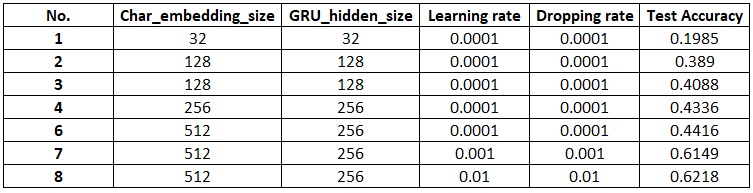